In [1]:
import duckdb
import pyarrow.dataset as ds
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, plot_roc_curve, PrecisionRecallDisplay
from sklearn.model_selection import train_test_split
from pympler import asizeof
from lightgbm import LGBMClassifier

In [2]:
dataset = ds.dataset("data/status", format="parquet", partitioning="hive")

In [3]:
con = duckdb.connect()
con = con.register("status", dataset)

In [4]:
station_ids = con.execute("select distinct(station_id) from status").df()["station_id"].values
len(station_ids)

472

In [6]:
for station_id in station_ids[11:12]:
    df_query = f"""
    WITH base_status AS (select
        station_id,
        hour,
        num_bikes_available,
        num_bikes_disabled,
        num_docks_available,
        num_docks_disabled,
        status,
        make_timestamp(year, month, day, hour, minute, 0.0) as ts,
    from
        status
    where
        make_timestamp(year, month, day, hour, minute, 0.0)
        between make_timestamp(2022, 6, 1, 0, 0, 0.0)
        and make_timestamp(2022, 9, 1, 0, 0, 0.0) and
        station_id = {station_id} and
        status = 'IN_SERVICE')"""
    df_query += " union ".join([
    f"""
    select
        station_id,
        hour,
        dayofweek(ts) as dow,
        num_bikes_available,
        num_bikes_disabled,
        num_docks_available,
        num_docks_disabled,
        minute(lead(ts, {i}) over (
            order by ts asc
        ) - ts)  as minutes_bt_check,
        lead(num_bikes_available, {i}) over (
            order by ts asc
        ) as remaining_bikes_available,
    from
        base_status
    """ for i in range(1, 17, 3)])
    dataset_df = con.execute(df_query).df()

In [7]:
dataset_df["remaining_bikes_available"] = (dataset_df["remaining_bikes_available"]>0).astype(int)

In [8]:
len(dataset_df)

108647

In [9]:
dataset_df["remaining_bikes_available"].value_counts(normalize=True)

1    0.98381
0    0.01619
Name: remaining_bikes_available, dtype: float64

In [142]:
FEATURES_ORDER = ["hour", "dow", "num_bikes_available", "num_bikes_disabled", "num_docks_available", "num_docks_disabled", "minutes_bt_check"]
TARGET = "remaining_bikes_available"
CLASS_WEIGHT = {0: 10000, 1: 1}
OHE_SLICE = [0, 1]
SS_SLICE = slice(2,7)
TEST_SIZE = 0.2

In [176]:
rf_pipeline = make_pipeline(
    ColumnTransformer([("ohe",  OneHotEncoder(sparse=False), OHE_SLICE), ("ss",  StandardScaler(), SS_SLICE)]),
    RandomForestClassifier(n_estimators=10, max_depth=10, class_weight=CLASS_WEIGHT))
dataset_df = dataset_df.dropna()
X_train, X_test, y_train, y_test = train_test_split(dataset_df[FEATURES_ORDER].values, dataset_df[TARGET].values, test_size=TEST_SIZE, shuffle=False)
rf_pipeline.fit(X_train, y_train)
rf_metrics = confusion_matrix(y_test, rf_pipeline.predict(X_test), normalize="true").ravel()

In [177]:
tn, fp, fn, tp = rf_metrics
print(f"tn: {tn}, fp: {fp}, fn: {fn}, tp: {tp}")

tn: 0.9859154929577465, fp: 0.014084507042253521, fn: 0.0803837676649812, tp: 0.9196162323350188


/home/dml/.cache/pypoetry/virtualenvs/research-bicisba-A0HrnKHR-py3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


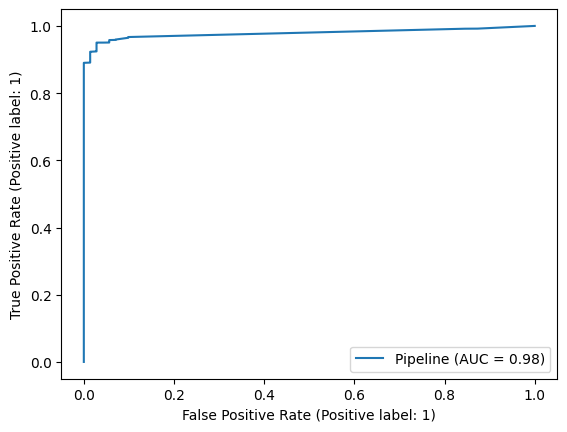

In [246]:
plot_roc_curve(rf_pipeline, X_test, y_test)

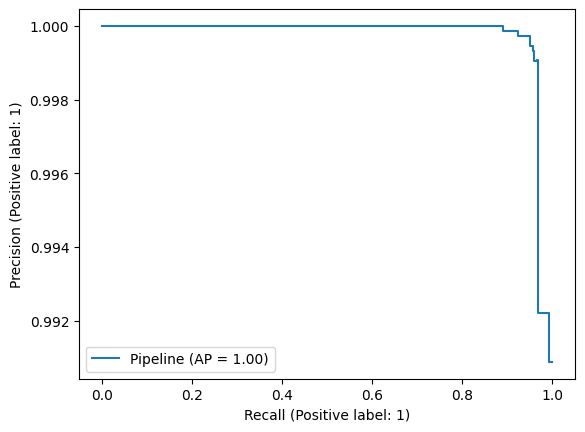

In [250]:
PrecisionRecallDisplay.from_estimator(rf_pipeline, X_test, y_test)

In [186]:
asizeof.asizeof(rf_pipeline)

17168

In [242]:
lgb_pipeline = make_pipeline(
    ColumnTransformer([("ohe",  OneHotEncoder(sparse=False), OHE_SLICE), ("ss",  StandardScaler(), SS_SLICE)]),
    LGBMClassifier(class_weight=CLASS_WEIGHT, n_estimators=5, max_depth=6))
lgb_pipeline.fit(X_train, y_train)
lgb_metrics = confusion_matrix(y_test, lgb_pipeline.predict(X_test), normalize="true").ravel()

In [243]:
tn, fp, fn, tp = lgb_metrics
print(f"tn: {tn}, fp: {fp}, fn: {fn}, tp: {tp}")

tn: 0.971830985915493, fp: 0.028169014084507043, fn: 0.07117852975495916, tp: 0.9288214702450408


/home/dml/.cache/pypoetry/virtualenvs/research-bicisba-A0HrnKHR-py3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


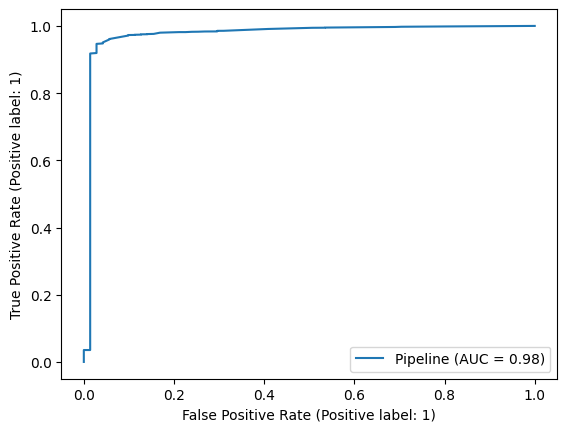

In [248]:
plot_roc_curve(lgb_pipeline, X_test, y_test)

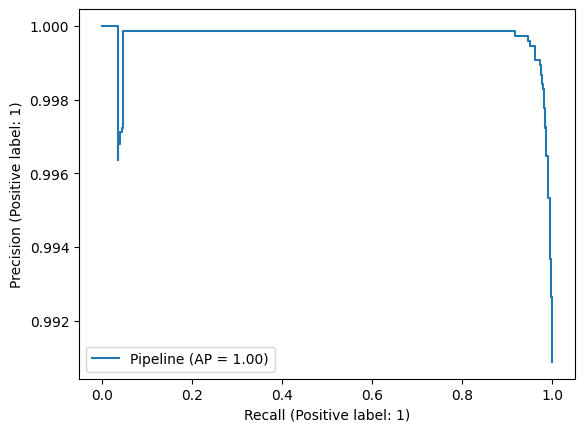

In [251]:
PrecisionRecallDisplay.from_estimator(lgb_pipeline, X_test, y_test)

In [244]:
asizeof.asizeof(lgb_metrics)

288